<div style="text-align: right"> Author: Caio Miyashiro </div>

# Introduction

## What is PCA?

So you're working with a dataset containing dozens of numerical variables explaining what you're working on the moment. Dozens of sensor data from weather data, hundreds of columns in customer transactional tables or thousands of variables explaining gene expression in microarray experiments. Sometimes this is just an overflow of information and we want to understand if we can obtain the same kind of knowledge from a possible smaller dataset.  

Not only we want to remove redundant information, but also to extract the main sources of information.  

Imagine if we knew that looking at the first two dimensions (*i.e.*, columns) of our data was the best place to start looking, instead of the number of pair of socks bought yesterday or the data from sensor #13323b compared to sensor #13323h. PCA allows us to automatically go trought this data jungle and find these new useful "Point of views". So, with no further ado, PCA:  
  
`PCA is a statistical technique that allow us to describe a set of possibly correlated observations into a possibly smaller set of linearly independent vectors.` [[Wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis)]

<img src="https://i.stack.imgur.com/lNHqt.gif" alt="pc-yey!" style="width: 900px;"/>
  
In a short list, PCA has some good characteristics:  
  
* It tends to identify the strongest patterns in the data, *i.e.*, PCA manage to find the best representative vectors
* Since most of the noise in the data is weaker than the patterns, dimensionality reduction can eliminate much of the noise
* Most of the variability of the data can be captured by a small fraction of the total set of dimensions

Wait, what? Variabilitydata in a setofdimensions? Calm down my boy, lets go one step at a time.    
  
## What does it mean to find the best vector?

Take a look at the picture below. In the context of PCA, we can be sure of two things here:  
1. Is a picture of a flock of birds
2. We are sure that when the picture was taken, the birds were flying on a 3D space (no questions on that).  
  
Even though we know the birds were flying on a tri-dimensional space, this 2-D photo makes us feel that we understand how the birds are flying, or how they are packed together. For instance, right on the center, we can see a blacker-ish center of birds, indicating that we could have more birds flying horizontally from where the picture was taken from. A question we can wonder is: `"If we looked through another angle, maybe from below or directly from above, would we be able to understand even better how the birds are flying together? Or even maybe identify separate groups of birds with different flying strategies?"`

<img src="https://i.ytimg.com/vi/bb9ZTbYGRdc/maxresdefault.jpg" style="width: 700px;"/>  
  
Point of views really can the decisive move we need to do in order to understand what we're looking at. The second example is a child challenge that plays with shadows in order to create a game where we have to define whether the shadow is a camel or a dromedary. 
  
<img src="images/camel.png" style="width: 700px;"/> 

# From Pictures to Points  

In Data Science, actually in Linear Algebra, a point of view is nothing more than a way we look at our data. If we are talking about the flock of birds, we could think of each being a data point in a 3-D space with 3 axis, one for width, second for the height and the final one for deepness.  
  
For any of these birds, if we only knew about their width in space, I wouldn't know anything about their position in the other two directions, or what we can call dimensions. The same happens for the other dimensions, knowing something about one or even two of then don't bring us any clue in terms of the last unknown dimension. When we migrate to the graphs and points we see on data science projects, these unique axis would define how we represent **everything** that happens inside it. So everything that is inside this picture, *e.g.*, the birds in our picture, could be uniquelly defined as a combination of these three axis.  

Why I am speaking like this? Coming back to our philosophical question with the bird flock: `What if we thought that if we looked diagonally to the birds it could actually help me see how are they spread or how organized they are?` Then, if we knew something about their deepness, we could actually be able to have a feeling of how high they are.  
  
Let's go for a bit more technical: Below is the 3-D picture of three columns from the [iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set): ['`sepal length (cm)`', '`sepal width (cm)`', '`petal length (cm)`']. I'm showing it in three dimensions, so we can easilly see the application of PCA, but this could be generalizable for bigger dimensions. For instance, the iris dataset is made of 5 explanatory variables but we're only seeing it in 3 now.  

  
First we have the interactive 3-D plot with the 3 defined variables. You probably won't be able to see it from Github; but only if download and rerun it. If you can't see the 3D plot on the code cell below, you can check it online [here](https://plot.ly/~c.miyashiro/2)

In [1]:
# https://ipyvolume.readthedocs.io/en/latest/

import plotly
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd
from sklearn import datasets

# https://plot.ly/python/3d-scatter-plots/

plotly.offline.init_notebook_mode(connected=True)

# Read data from a csv
iris_data = datasets.load_iris()
df = pd.DataFrame(iris_data['data'], columns=iris_data['feature_names'])

trace = go.Scatter3d(
    x = df['sepal length (cm)'].values,
    y = df['sepal width (cm)'].values,
    z = df['petal length (cm)'].values,
    mode = "markers",
    marker=dict(
        size=5,
        opacity=0.8
    )    
)

layout = go.Layout(
    title='Iris Data Points',
    autosize=False,
    width=500,
    height=500
)

plotly.offline.iplot({
    "data": [trace],
    "layout": layout
})

By spinning the scatter plot above, we can think how the best view would bring us more information, *i.e.*, how spread the points are.  
  
Below, I show you 3 pictures from the 3-D plot above, containing 3 different rotations of the origina data. `If you looked at them, which one would you prefer to carry on with your analysis?`  

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

_, ax = plt.subplots(1,3,figsize=[17,5])

ax[0].imshow(mpimg.imread('images/p1.png'))
ax[1].imshow(mpimg.imread('images/p2.png'))
ax[2].imshow(mpimg.imread('images/p3.png'));

I bet you, or I hope at least, that the majority of people chose the **3rd picture**.  In it, we can have a better idea of not just one, but two distinct groups. 

Now that we know what to look for when applying PCA we have to think, `how to do this automatically?`

**Math warning!**
In the following steps, we will deep deeper on the mathematical formulation and solution. Unfortunately it isn't possible to go deep in all the following techniques. I'll provide links as best as possible but it is by no means a complete approach to define principal components. To have a better understanding, I'll assume you have general knowledge on the following topics:
  
* Linear Algebra
* Optimisation - Gradient and Partial Derivatives

  
If you just want to apply PCA in your problem, you can go directly to the section ["Hands On"](#Hands-on)

# Problem definition

## Vector Projections

When we want to change our perspectives, *i.e.*, our axis in our data, we're talking about [vector projections](https://en.wikipedia.org/wiki/Vector_projection). In our iris dataset, instead of thinking about points in a scatter plot, we can think of each being a vector starting from the origin. If we have any other vector, we can project the data point into the new vector by just dot product the data point vector with the [normalized projection](https://en.wikipedia.org/wiki/Unit_vector) vector and then multiplying it again by the normalised projection vector.
  
$$proj(a,b) = a . \frac{b}{|b|} * \hat{b}$$

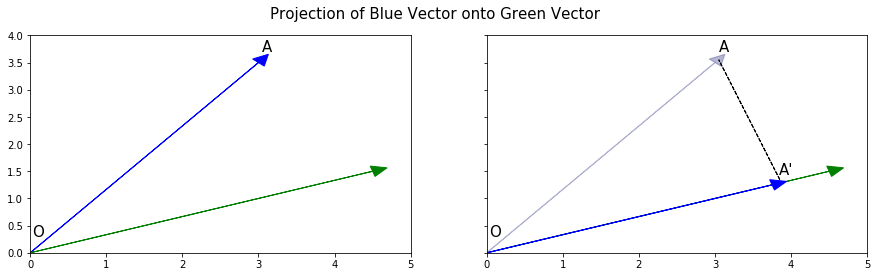

In [3]:
import numpy as np
from numpy.linalg import norm

a = np.array([3, 3.5])
b = np.array([4.5, 1.5])

fig, ax = plt.subplots(1,2,figsize=[15,4], sharex=True, sharey=True)

fontsize = 15
fig.suptitle('Projection of Blue Vector onto Green Vector', fontsize=fontsize)

arrow_head_size = 0.2
ax[0].arrow(0,0, a[0], a[1], color='blue', head_width=arrow_head_size, head_length=arrow_head_size)
ax[0].arrow(0,0, b[0], b[1], color='green', head_width=arrow_head_size, head_length=arrow_head_size)
ax[0].set_xlim([0,5])
ax[0].set_ylim([0,4])
ax[0].text(0.03, 0.3, 'O', fontsize=fontsize)
ax[0].text(a[0]+.05, a[1]+0.2, 'A', fontsize=fontsize)

########### 

projection = np.dot(a, b / norm(b)) * b / norm(b)
ax[1].arrow(0,0, a[0], a[1], color='#0B116A', alpha=0.3, head_width=arrow_head_size, head_length=arrow_head_size)
ax[1].arrow(0,0, b[0], b[1], color='green', head_width=arrow_head_size, head_length=arrow_head_size)
ax[1].arrow(0,0, projection[0], projection[1], color='blue', head_width=arrow_head_size, head_length=arrow_head_size)
noise = .05
ax[1].arrow(a[0] + noise, a[1] + noise, 
            projection[0] - a[0] + noise, projection[1] - a[1] + noise,
            color='black', linestyle='--')

ax[1].text(0.03, 0.3, 'O', fontsize=fontsize)
ax[1].text(a[0]+.05, a[1]+0.2, 'A', fontsize=fontsize)
ax[1].text(projection[0]+.09, projection[1]+0.2, "A'", fontsize=fontsize);


When we project, we want two things:
1. As a projection quality, we don't want to distort our data and lose their meaning. Therefore, we want the [vector rejection](https://en.wikipedia.org/wiki/Vector_projection#Vector_rejection) to be the smallest as possible
2. As a PCA objective, we want the projected data to be as spread as possible  
  
As we'll check, both criterias work together.  

Let dist(x,y) be the euclidean distance between points x and y above. We know the **dist(O,A) is fixed by the data**. If we want to **minimise dist(A,A')** (criteria 1), from the pythagoras theorem, we know that we **need to maximize dist(O,A')** as most as possible

$$dist(O,A)^{2} = dist(O,A')^{2} + dist(A,A')^{2}$$

Because of mathematical criterias for future PCA properties, we want to define a vector $w$ whose length = 1, *i.e.*, $|w| = 1$. This will help us to set our optimisation problem and also impose constraints over it. 

Some useful definitions before following on, extracted from [reference1](https://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch18.pdf) and [reference2](https://stats.stackexchange.com/questions/217995/what-is-an-intuitive-explanation-for-how-pca-turns-from-a-geometric-problem-wit). Not much intuition from its origins but they'll help us in the following sections

***
   
**Definition 1**: Given $x \epsilon \mathbb{R}^{n}$. If $w$ is a unit vector, the length of the vector projection of x onto $w$ will be defined by their dot product:
$$dist(O,A') = x . w = \sum_{i=1}^{n} x_{i} * w_{i}$$  
  
Matrix notation. If $X \epsilon \mathbb{R}^{m,n}$ with $m$ rows and $n$ columns. The calculation above can be obtained by:  

$$dist(O,A') = Xw $$  
  
  
  
**Definition 2**: Given a data matrix $X \epsilon \mathbb{R}^{m,n}$, if the data is mean centered, *i.e.* $x_{i,j} = x_{i,j} - \bar{x}_{j}$, its [covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix) can be defined as:  
  
$$cov(X) = \frac{1}{m-1} X^{t}X$$  

***
  
## Optimization Problem

Given the projections distances $X^{t}w$, we can define this as an optimisation problem where we want to optimise the variance of the projections  
$$cov(Xw) = \frac{1}{m-1} (Xw)^{t}Xw$$

Bringing the transpose inside the parenthesis and inverting the new $w^{t}$  with the constant $\frac{1}{m-1}$ we have:
$$ = w^{t}(\frac{1}{m-1} X^{t}X)w$$  
  
The element in parenthesis is just the covariance matrix from the data matrix $X = C$. So we just rewrite it adding the optimisation objective:
  
$$\underset{w}{arg \space max} \space cov(X^{t}w) = w^{t}Cw$$

## Adding a Constraint for Unit Vector
  
From the last equation from the previous section, we saw that, if we keep creating bigger vectors $w$, we would be always be optimising for the variance of the projections and then the problem would be ill-defined. For that, we define that $w$ should be `unit variance`. However, `how do we account for unit vectors in our optimisation problem?`  
  
[Lagrange Multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier) is a technique with the objective to find maximal or minimal of a function subject to constraints, more specifically, equality constraints. In our problem, our constraint criteria is that the norm of our projection vectors should be 1, *i.e.* $w^{t}w = 1$.  
  
With that, our new Lagrangian optimisation function becomes: optimise $cov(X^{t}w) = w^{t}Cw$ subject to $w^{t}w = 1$  
  
$$\mathcal{L} = w^{t}Cw - \lambda(w^{t}w - 1)$$ 
  
After we added the Lagrange Multiplier, we just treat the above equation as a unconstrained optimisation. We set the partial derivatives "with relation to" (w.r.t.) $w$ and $\lambda$ to 0 and find the equation solutions

http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf
  
## Solution to Optimization
  
Our variables in the last equations are the projection vector $w$ and a scalar multiplier $\lambda$. Taking the partial derivative w.r.t. both variables, we have find some traditional matrices structures in our formula, where we use a [cheat sheet](http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf) and [another PCA manual](https://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch18.pdf) in order to easily get the derivative:  

$$\frac{\partial \mathcal{L}}{\partial w} = 2wC - 2\lambda w$$  
$$\frac{\partial \mathcal{L}}{\partial \lambda} = w^{t}w - 1$$  
  
Setting the derivatives to 0 and reorganising the equation a little bit we get:  
  
$$w^{t}w = 1$$  
$$Cw = \lambda w$$  
  
The 2nd solution equation above is a very famous structure where we find a set of vectors $w$ which, under a linear transformation map C, it only scales by a factor of $\lambda$. Yes my dear, unfortunately we're talking about [eigenvalues and eigenvectors](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) and the solution to what we're looking for, *i.e.*, `set of vector(s) $w$ where we project our data with minimal distortion and maximum variance` are the eigenvectors of C, *i.e.* the covariance matrix of X. Wow! So now we know $w$ will be among one of the candidates eigenvectors of C.
  
As you can see on the reference, eigenvectors and values have a multitude of applications and interpretations. I'll leave you the challenge to discovery how to geometrically connect the eigenvectors of our data matrix with the PCA solutions. When you find out, please tell me because I have no ideas.

<img src="https://i.imgur.com/AfgkjCf.jpg" style="width: 400px;"/> 

One last thing, we know [from linear algebra](https://math.oregonstate.edu/home/programs/undergrad/CalculusQuestStudyGuides/vcalc/eigen/eigen.html) a few facts from our eigenvectors/values from $C$:  

* C is a **symmetric matrix**, so we know that:  

    * Eigenvectors will be orthogonal to each other: This is a good thing, as orthogonal vectors covers (`span` in linear algebra terms) the whole space. For instance, with n eigenvectors we are sure that we can represent everything up to n dimensions.  
     
     
* C is also a **covariance matrix**, so we'll also have the following property:  
  
    * It will have $n$ distinct pairs eigenvalues/eigenvectors. As we will look in future topics, the best way to represent PCA in $D$ dimensions, with $D < N$ features, is to use the set of $D$ eigenvectors from the data table covariance matrix. However, this raises up the question. `If we have n eigenvectors associated to C, which of them should we use for our optimisation problem?` 
  
For this, we just have to fit our possible solutions into the original objective function (variance maximisation):

Given that we found $Cw = \lambda w$,  
  
$$cov(X^{t}w) = w^{t}Cw = w^{t}\lambda w = \lambda w^{t}w = \lambda$$

That's quite remarkable! So given we have our set of potential solution eigenvectors, `the variance of the Xw is going to be equals to its eigenvalue`. **And**, as we have a set of distinct eigenvalues by the covariance matrix properties, we just have then to sort from the biggest to the smallest eigenvalue and bring the according eigenvectors :D  
  
That was crazy.  

## Summary

Showing the theory behind a technique is always harder than its practice, as we will see on the next sections that we can manually perform PCA on a few programming lines or even use scikit package to call a one-line-function. Even though it makes our lives easier, I always though that it's good to know what is running behind the curtains, so we know what we're doing and more important, whether it makes sense or not. Here it goes what've seen until now summarized:  
  
***  

* PCA finds the best vectors (point of views) to look at our data 
* Good vectors means creating them in such a way that the projection of X onto them is as spread as possible
* Finding these vectors can be formulated as an optimisation problem which involves lots of matrices calculus, lagrange multipliers and eigenvectors and eigenvalues
* We proved that the solutions for the optimisation problem are the eigenvalues of the covariance matrix of the dataset 
* Finally, the eigenvectors must be sorted by their eigenvalues in order to create from the best principal component to the worst, *i.e.*, the vector who explains more variance to the one who explains the least.
  
***  
  
# Hands on

After all the math, we will see how scikit PCA command is working behind the curtains, where we will calculate all the intermediary steps ourselves and then we will use the prompt command to easily create our principal components. Besidse, we will see some practical techniques that will help us to obtain more reliable results. Finally, we'll bring techniques on how to evaluate the output provided by the technique, the principal components. 
  
For context, we will work with the [decatlon data](https://pbil.univ-lyon1.fr/ade4/ade4-html/olympic.html) [[link to dataset](https://www.fun-mooc.fr/c4x/agrocampusouest/40001S03EN/asset/data_PCA_Decathlon.csv)], which contains the performance of 41 athletes in multiple sport modalities and their final rank, for 2 competitions.  
  
## Reading Data 

41 Athlets, 13 Variables  
  
* 10 Numerical variables: Athlets's performance for 10 events
* 2 Nominal variables: The rank and the number of points
* 1 Categorical variable: Competition - OG2004 or Decastar  

In [4]:
df = pd.read_csv('data_PCA_Decathlon.csv', sep=';', index_col=0)
print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (41, 13)


,100m,Long jump,Shot put,High jump,400m,110m H,Discus,Pole vault,Javeline,1500m,Rank,Points,Competition
Sebrle,10.85,7.84,16.36,2.12,48.36,14.05,48.72,5.0,70.52,280.01,1,8893,OlympicG
Clay,10.44,7.96,15.23,2.06,49.19,14.13,50.11,4.9,69.71,282.00,2,8820,OlympicG
Karpov,10.50,7.81,15.93,2.09,46.81,13.97,51.65,4.6,55.54,278.11,3,8725,OlympicG
Macey,10.89,7.47,15.73,2.15,48.97,14.56,48.34,4.4,58.46,265.42,4,8414,OlympicG
Warners,10.62,7.74,14.48,1.97,47.97,14.01,43.73,4.9,55.39,278.05,5,8343,OlympicG


The first approaches to PCA only deals with `numerical` data. We have ways to insert information about nominal and categorical variables but lets first see the results only with the numerical columns

## Preprocessing - Standardisation

In the PCA definition, we saw that it finds the vectors with maximum variance. Lets say you have two different variables explaining the human economic status:  
  
* Variable 1: Age, *i.e.*, number of years  
* Variable 2: Average monthly expense in euros
  

  

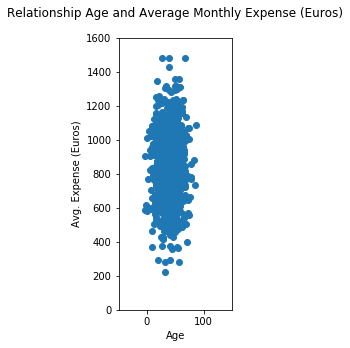

In [5]:
from numpy.random import normal

age = normal(loc=40, scale=15, size=1000)
expense = normal(loc=800, scale=200, size=1000) + age

fig, ax = plt.subplots(figsize=[10,5])
ax.scatter(age, expense)
ax.set_xlabel('Age')
ax.set_ylabel('Avg. Expense (Euros)')
ax.set_title('Relationship Age and Average Monthly Expense (Euros)\n')
ax.set_aspect(aspect = .3)
ax.set_xlim([-50,150])
ax.set_xticks([0, 100])

ax.set_ylim([0,1600]);

If you plot these two variables in a scatter plot, "*Age*" on x-axis and "*Expense*" on y-axis. If we look at the picture as a whole, we can imagine the cloud of points would be cilindrical with the y-axis way more stretched than the x-axis. If we applied PCA on this format, it would find the biggest vector in the same direction as the "*Expense*" variable because it actually provides us with the biggest variance, even though it might not provide us with useful information.  

`PCA gives high importance for variables with high variance unit`  

How can we make all variables in the same unit and in this way, make PCA look at them with the same importance?
  
By standardising the data, we make all numerical columns having mean 0 and standard deviation 1. All variables will have the same units in this case, the number of standard deviations it deviates from the mean.

$$Standardisation \space c_{i} = \frac{c - \bar{c}}{sd_{c}}$$  

Scikit provides a class to automatically standardise our data, [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). We select our numerical columns and apply the standard scaler on them:

In [6]:
from sklearn.preprocessing import StandardScaler

numerical_cols = df.columns[:10]
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df[numerical_cols]), columns=numerical_cols, index=df.index)
df_scaled.head()

,100m,Long jump,Shot put,High jump,400m,110m H,Discus,Pole vault,Javeline,1500m
Sebrle,-0.569866,1.855886,2.312292,1.629550,-1.102733,-1.192819,1.317106,0.865152,2.559659,0.085440
Clay,-2.148030,2.239862,0.924617,0.946638,-0.374214,-1.021145,1.733723,0.500971,2.389762,0.258033
Karpov,-1.917079,1.759891,1.784239,1.288094,-2.463221,-1.364493,2.195299,-0.591572,-0.582387,-0.079348
Macey,-0.415899,0.671959,1.538633,1.971006,-0.567316,-0.098398,1.203211,-1.319934,0.030081,-1.179954
Warners,-1.455178,1.535905,0.003594,-0.077730,-1.445050,-1.278656,-0.178519,0.500971,-0.613850,-0.084551


## Calculate Covariance Matrix from Data

When we take the covariance matrix of a standardised dataframe, *i.e.* $\mu = 0, \sigma^{2} = 1$, the result will be on the form of a correlation matrix, where $C_{i,j} =$ correlation between $i,j$.  
  
Although is advisable to perform PCA on standardised data (see previous section), performing the technique with or without standardisation results in different components.  

If your variables have the same unit variance, their covariance will also have their combined unit, while correlation is just a normalised approximation, throwing out a lot of information regarding the context. See discussion on [this thread](https://stats.stackexchange.com/questions/53/pca-on-correlation-or-covariance) for more informations.  
  
For us, as we though our variables had different scales, we normalised them before extracting the correlation matrix.  

In [7]:
from numpy import cov

cov_X_t = cov(df_scaled.transpose())
print('"Correlation" Matrix from X: \n')
pd.DataFrame(cov_X_t, columns=df_scaled.columns, index=df_scaled.columns)

"Correlation" Matrix from X: 



,100m,Long jump,Shot put,High jump,400m,110m H,Discus,Pole vault,Javeline,1500m
100m,1.025000,-0.613645,-0.365394,-0.252409,0.533306,0.594386,-0.227250,-0.084600,-0.161690,-0.062060
Long jump,-0.613645,1.025000,0.187887,0.302011,-0.617114,-0.518045,0.199168,0.209114,0.122753,-0.034528
Shot put,-0.365394,0.187887,1.025000,0.501442,-0.141894,-0.257906,0.631162,0.062711,0.384329,0.118698
High jump,-0.252409,0.302011,0.501442,1.025000,-0.192656,-0.290371,0.378449,-0.160085,0.176177,-0.046025
400m,0.533306,-0.617114,-0.141894,-0.192656,1.025000,0.561687,-0.120826,-0.081275,0.004338,0.418309
110m H,0.594386,-0.518045,-0.257906,-0.290371,0.561687,1.025000,-0.334356,-0.002771,0.008962,0.038479
Discus,-0.227250,0.199168,0.631162,0.378449,-0.120826,-0.334356,1.025000,-0.153824,0.161837,0.264629
Pole vault,-0.084600,0.209114,0.062711,-0.160085,-0.081275,-0.002771,-0.153824,1.025000,-0.030751,0.253634
Javeline,-0.161690,0.122753,0.384329,0.176177,0.004338,0.008962,0.161837,-0.030751,1.025000,-0.184903
1500m,-0.062060,-0.034528,0.118698,-0.046025,0.418309,0.038479,0.264629,0.253634,-0.184903,1.025000


## Extract Eigenvalues and Eigenvectors from Covariance Matrix 

In [8]:
from numpy.linalg import eig

ein_values, ein_vectors = eig(cov_X_t)

First time I compared the manual approach with scikit's implementation I got opposite signals in all elements from all eigenvectors. Searching a little bit, I found this [answer](https://stats.stackexchange.com/questions/88880/does-the-sign-of-scores-or-of-loadings-in-pca-or-fa-have-a-meaning-may-i-revers)

Indeed, when we evaluate an eigenvector, we are actually evaluating its line and not direction (+ or - sign). Therefore a different signal doesn't imply a different result, it just means the function that extracted the eigenvectors from the data looked to the opposite side, *i.e.*, 180°, when defining the eigenvectors.  
  
In order to be able to completely compare the manual approach with scikit's implementation, I multiplied the PCs by -1, *i.e.*, rotated the principal components by 180°, but we know by the link above that we're **not** changing our results!

In [9]:
ein_vectors = ein_vectors * -1

## Sort Eigenvalues and Get Corresponding Eigenvectors

In [10]:
from numpy import argsort

n_eigenvectors = 2
eigenvalues_sorted_indices = argsort(ein_values)[::-1]
eigenvectors = ein_vectors[:,eigenvalues_sorted_indices[:n_eigenvectors]]

print('First Two Eigenvectors: \n')
print(eigenvectors)


First Two Eigenvectors: 

[[-0.42829627  0.14198909]
 [ 0.41015201 -0.26207936]
 [ 0.34414444  0.45394697]
 [ 0.31619436  0.2657761 ]
 [-0.3757157   0.432046  ]
 [-0.41255442  0.17359096]
 [ 0.30542571  0.4600244 ]
 [ 0.02783081 -0.13684105]
 [ 0.15319802  0.24050715]
 [-0.03210733  0.35980486]]


## Transform Original Data and get Transformations (Loadings)

eigenvector = $w$  
  
Loadings = $Xw$

In [11]:
loadings = df_scaled @ eigenvectors
loadings = loadings.rename(columns={0:'pc1', 1:'pc2'})
loadings.head()

,pc1,pc2
Sebrle,4.038449,1.365826
Clay,3.919365,0.836961
Karpov,4.619987,0.039995
Macey,2.233461,1.041766
Warners,2.168396,-1.803200


## Apply Scikit PCA and Compare with Manual PCA

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Comparing the output with the previous cells, we see that we already get the same loadings for our instances :DD

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=df_scaled.shape[1])

pc_df = pd.DataFrame(pca.fit_transform(df_scaled), 
                     columns = [f'principal_component_{i}' for i in range(1,df_scaled.shape[1]+1)],
                     index = df_scaled.index)

print(f'First {n_eigenvectors} Principal Components: \n')
pca_components = pca.components_[:n_eigenvectors].transpose()
print(pca_components)

print('\nTransformed Data:')
print(f'Shape: {pc_df.shape}')
display(pc_df.iloc[:,:n_eigenvectors].head())

First 2 Principal Components: 

[[-0.42829627  0.14198909]
 [ 0.41015201 -0.26207936]
 [ 0.34414444  0.45394697]
 [ 0.31619436  0.2657761 ]
 [-0.3757157   0.432046  ]
 [-0.41255442  0.17359096]
 [ 0.30542571  0.4600244 ]
 [ 0.02783081 -0.13684105]
 [ 0.15319802  0.24050715]
 [-0.03210733  0.35980486]]

Transformed Data:
Shape: (41, 10)


,principal_component_1,principal_component_2
Sebrle,4.038449,1.365826
Clay,3.919365,0.836961
Karpov,4.619987,0.039995
Macey,2.233461,1.041766
Warners,2.168396,-1.803200


# Evaluating

## How many PCs should I choose?
  
After calling our PCA function, we get back at most $n$ principal components, where $n$ is the number of columns in our data matrix X. We have discussed that one of the benefits of using PCA is that we can represent a high dimensional data using less axis and keeping most of the variance. However, if we have at most the same number of eigenvectors as columns, `how should I choose the number of PCs to represent my data?`. Lets take a look at the concept of `explained variance` in order to understand how we can use it to select the number of pc's

### Variance Explained  
      
We saw before that the eigenvalues $\lambda_{i}$ from the covariance matrix [represented the variance of the our original dataset](#Solution-to-Optimization). The fact we project our data, *i.e.*, transform it, doesn't change their variance. 
  
In fact, we can see below how their values are the same, as they represent the same thing. Variable `cov_X_t` was calculated in the manual steps to obtain the principal components. Getting the trace of this matrix is equal to the sum all of its diagonal components, *i.e.* the variance of each variable.

In [34]:
print(f'Sum of Variances from Covariance Matrix: {np.trace(cov_X_t)}')
print(f'Sum of Variances from Eigenvalues: {np.sum(ein_values)}')

Sum of Variances from Covariance Matrix: 10.25
Sum of Variances from Eigenvalues: 10.250000000000002


As this is a correlation matrix (covariance matrix of standardised data), the diagonals will be always equal `1`. So we see that each variable has it's own variance, *i.e.*, it explains itself. By checking the eigenvalues values, we can interpret them as how well they explain the data instead of each of the original columns.  
  
By summing up the original variance (~number of columns as all elements from covariance matrix = 1) and calling it total variance, we can calculate the explained variance of a principal components with the ratio of it with the total variance [[Reference](https://ro-che.info/articles/2017-12-11-pca-explained-variance)].  Then, we could interpret that any eigenvalue > 1 has a better explanation cabability, *i.e.*, it contains more variance from the original dataset, than any of the original variables.  
  
Lets sum all the eigenvalues and then calculated the percentage of each from the total. Remember we stored our eigenvalues in the variable `ein_values` and a sorted index version of it in `eigenvalues_sorted_indices`

In [14]:
eigenvalues_ = ein_values[eigenvalues_sorted_indices] # get sorted eigenvalues
print('Sorted Eigenvalues: ')
print(eigenvalues_)

sum_eigenvalues = np.sum(eigenvalues_)
print('\nRatio of Explained Variance:')
ratio_eigenvalues = eigenvalues_/sum_eigenvalues
ratio_eigenvalues_2 = np.round(ratio_eigenvalues * 100, 2)
print([f'{re}%' for re in ratio_eigenvalues_2])

Sorted Eigenvalues: 
[3.35370318 1.7805593  1.4400396  1.08327161 0.70189287 0.6142504
 0.46251615 0.4067985  0.22018522 0.18678317]

Ratio of Explained Variance:
['32.72%', '17.37%', '14.05%', '10.57%', '6.85%', '5.99%', '4.51%', '3.97%', '2.15%', '1.82%']


The same values are stored in `explained_variance_ratio_` variable when we use scikit's PCA command:

In [15]:
sk_expl_var = np.round(pca.explained_variance_ratio_ * 100, 2)
print([f'{re}%' for re in sk_expl_var])

['32.72%', '17.37%', '14.05%', '10.57%', '6.85%', '5.99%', '4.51%', '3.97%', '2.15%', '1.82%']


The numbers represent how much variance each principal component explains from the total variance that existed on the original data matrix. There are a few interpretations for explained variance and a good one is [here](https://ro-che.info/articles/2017-12-11-pca-explained-variance). In short, in a correlation matrix context, the explained variance of a principal component of x% means it is equivalent of x% of the summed variance from the whole data matrix.  
  
In the decatlon dataset, the first principal component explains roughtly 1/3 of the columns total variance.  
  
We want to keep as most as variance as possible, but we also want to decrease dimensionality. What we can do is to plot the explained variance individually and accumulative and decide what is the best trade-off for us:  

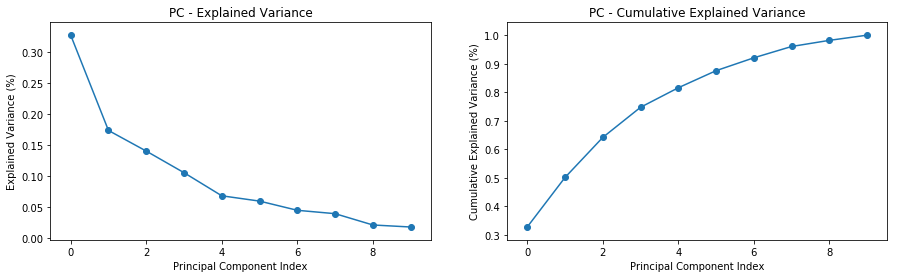

In [16]:
def plot_explained_variance(pca_explained_variance_ratio_):
    fig, ax = plt.subplots(1,2,figsize=[15,4])

    ax[0].plot(pca_explained_variance_ratio_)
    ax[0].scatter(range(len(pca_explained_variance_ratio_)), pca_explained_variance_ratio_)
    ax[0].set_title('PC - Explained Variance')
    ax[0].set_xlabel('Principal Component Index')
    ax[0].set_ylabel('Explained Variance (%)');

    accumulative_expl_var = []
    for i in range(len(pca_explained_variance_ratio_)):
        accumulative_expl_var.append(np.sum(pca_explained_variance_ratio_[:i+1]))
    ax[1].plot(accumulative_expl_var)
    ax[1].scatter(range(len(accumulative_expl_var)), accumulative_expl_var)
    ax[1].set_title('PC - Cumulative Explained Variance')
    ax[1].set_xlabel('Principal Component Index')
    ax[1].set_ylabel('Cumulative Explained Variance (%)'); 
    
plot_explained_variance(pca.explained_variance_ratio_)    

### Rules of Thumb When Deciding Number of Principal Components

When thinking on how many principal components to represent our data, we have one main approach:  
  
  
** Fix the desired explained variance and extract the appropriate number of principal components - [Coursera Video](https://www.coursera.org/lecture/machine-learning/choosing-the-number-of-principal-components-S1bq1): **

* Lets say you decided to get at least 90% of the variance explained. We can take a look at the cumulative plot and get all the principal components until the y-axis reaches 90%. On this case for example, we would get the 6 first components.  
  
* We could have more automatic approaches, such as looking at the gradient of the explained variable function, and get all the components until we reach a plateau, *i.e.*, adding more components wouldn't bring sufficient benefits for us.
  
## Correlation Circle  

One advantage of using PCA is that we can get a good representation of variables' correlation. When we look at the raw data, we tend to get this sort of information from [correlation matrices](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html). In higher dimension $\epsilon \space \mathbb{R}^{n}$ the correlation matrix would be symmetric with $n$ columns, leading to a hard time understanding their relationships.  
  
For most cases, the first 2 components explain the majority (> 50%) of the data variability. When we have this situation, we interpret this as the main directions and, if some variable tend to have the same direction, *i.e.*, if variable x grows, principal component x will grow too, we can have a feeling of the variable's importance. Furthermore, as we have a graphical representation, we can also see if 1 or more variables are correlated together in an easier way.  
  
When data isn't standardised, we have to calculate the correlation of each variable with the principal components (for visual representations, this is usually done with the first 2 principal vectors). When we are working with correlation matrices, the correlation can be easily extracted from the principal components itself. Principal components are unit length, so the bigger the weight the pc gives to that variable, the more it contributes to its final value.  
  
In the following plot, principal components 1 and 2 on x and y axis respectively. We can also see on the axis that these two vectors explains roughtly 50% of the variance. The correlation circle plots the correlation between each column and each pc as an arrow. The closer the arrows align with the axis, the more important the variables are to the components. Besides, arrows pointing to the same direction are a strong evidence that they are correlated as well.

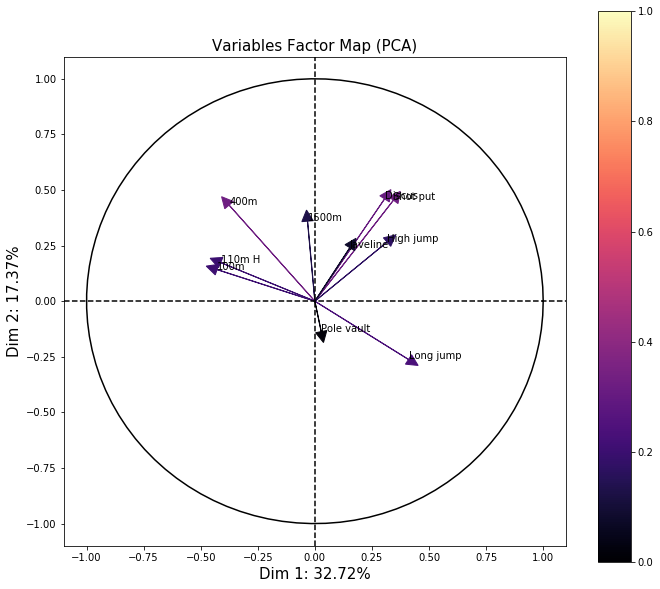

In [17]:
from adjustText import adjust_text

import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl

# for text overlaying: https://github.com/Phlya/adjustText
def plot_pca_factor_map(pca, scaled_data):
    """
    Plot a variable factor map for the first two dimensions.
    """
    (fig, ax) = plt.subplots(figsize=(9, 9))
    text_list = []
    repres_quality = pca.components_[0,:] ** 2 + pca.components_[1,:] ** 2
    cmap = plt.cm.magma
    cNorm  = colors.Normalize(vmin=0, vmax=1)
    scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)
    
    for i in range(0, len(numerical_cols)):
        colorVal = scalarMap.to_rgba(repres_quality[i])
        ax.arrow(0,
                 0,  # Start the arrow at the origin
                 pca.components_[0, i],  #0 for PC1
                 pca.components_[1, i],  #1 for PC2
                 head_width=0.05,
                 head_length=0.05,
                 color=colorVal)

        text_list.append(ax.text(pca.components_[0, i],
                 pca.components_[1, i],
                 scaled_data.columns.values[i]))

    axc = fig.add_axes([.95, 0.10, 0.05, 0.85]) # [left, bottom, width, height]
    cb1 = mpl.colorbar.ColorbarBase(axc, cmap=cmap, norm=cNorm,orientation='vertical')
 
    an = np.linspace(0, 2 * np.pi, 100)
    ax.plot(np.cos(an), np.sin(an), color='black')  # Add a unit circle for scale

    ax.axhline(0, color='black', linestyle='--')
    ax.axvline(0, color='black', linestyle='--')

    fontsize = 15
    ax.set_title('Variables Factor Map (PCA)', fontsize=fontsize)
    expl_var0 = round(pca.explained_variance_ratio_[0] * 100, 2)
    expl_var1 = round(pca.explained_variance_ratio_[1] * 100, 2)
    ax.set_xlabel(f'Dim 1: {expl_var0}%', fontsize=fontsize)
    ax.set_ylabel(f'Dim 2: {expl_var1}%', fontsize=fontsize)
    plt.show()
    
    ########################
    
#     if(scaled_data is not None):
             
        
plot_pca_factor_map(pca, df_scaled)

We can see that variables are not that well represented on the principal components, having usually some correlation value of .5, *i.e.*, 45°. While lots of variables contribute in an average way to the 1st pc, the second pc is represented almost entirely by the "1500m" variable.   
  
At least we can get a feeling of how variables are correlated. For instance, we can see how athlets that tend to do well on small distance runnings (100 and 110 meters run), don't do well on average for the "Long Jump" modality.  
  
### Quality of Representation

We saw some variables get more or less correlated with the principal components. Some arrows were bigger or shorter on the unit circle above. This indicates how strongly correlated the variables are.  
  
The challenge is, if the variables aren't correlated with our main pc's, there is a risk on interpreting the relationship of this variable with others for example. In the context of PCA of correlation matrices, the projection quality indication is the $cos(\theta)^2$, or the [$(coordinates \space of\space pca \space variables)^2$](http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/112-pca-principal-component-analysis-essentials/). The variables are indicated on the plot above as the color of the arrow, from 0 to 1, black to yellow, bright variables indicate a trustworthy projected variable, while darker one must be evaluated with caution.

## Variable PCA Plot  
  
The same way we evaluate the variables based on the PCA vectors, we can do the same for each instance, *i.e.* dataset row. Instead of looking at the PCA components, we now plot the loadings ($Xw$) on the first two pc's. The plot is a complement for the correlation plot. The instances' positions on the variable PCA plot relates how these variables perform in the most important variables to each principal components

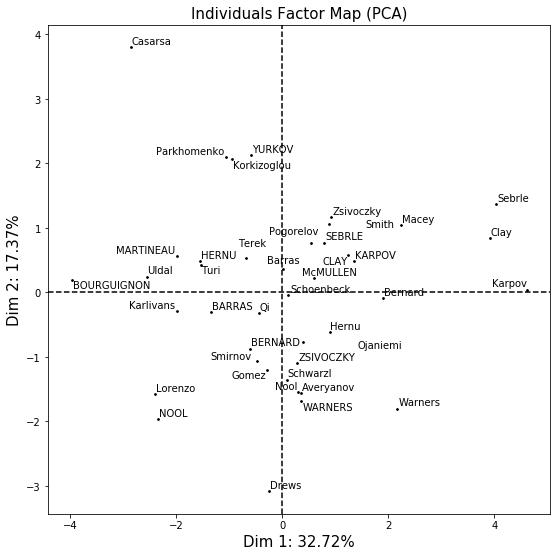

In [18]:
def plot_variable_pca(pca, scaled_data, flag_adjust_text=True):
    (_, ax) = plt.subplots(figsize=(9, 9))
    pc_transform = pca.transform(scaled_data)

    text_list = []
    for i in range(pc_transform.shape[0]):
        ax.scatter(pc_transform[i, 0],
                pc_transform[i, 1],color='black',s=3) # s = size
        text_list.append(ax.text(pc_transform[i, 0],
                pc_transform[i, 1],
                scaled_data.index.values[i]))
    if(flag_adjust_text == True):
        adjust_text(text_list)

    fontsize = 15
    expl_var0 = round(pca.explained_variance_ratio_[0] * 100, 2)
    expl_var1 = round(pca.explained_variance_ratio_[1] * 100, 2)
    ax.set_xlabel(f'Dim 1: {expl_var0}%', fontsize=fontsize)
    ax.set_ylabel(f'Dim 2: {expl_var1}%', fontsize=fontsize)
    ax.set_title('Individuals Factor Map (PCA)', fontsize=fontsize)

    ax.axhline(0, color='black', linestyle='--')
    ax.axvline(0, color='black', linestyle='--')

    plt.show()
    
plot_variable_pca(pca, df_scaled, True)    

Considering the two variable vectors from the correlation plot, *400m* and *long jump*, we might have an idea of athlets who performs good on the short run but we might have some intuitions that these same athlets don't perform good on jumping sports. Lets take a look at two athlets, "Parkhomenko" and "Warners"



In [19]:
athlets = ['Parkhomenko', 'Warners']
df_scaled.loc[athlets]

,100m,Long jump,Shot put,High jump,400m,110m H,Discus,Pole vault,Javeline,1500m
Parkhomenko,0.546396,-2.079872,1.489512,0.605182,1.249593,0.588297,-0.727015,0.136790,1.573837,-0.094092
Warners,-1.455178,1.535905,0.003594,-0.077730,-1.445050,-1.278656,-0.178519,0.500971,-0.613850,-0.084551


Parkhomenko has indeed some better skills on short and middle races, but performs poorly on jumping sports. The opposite happens for Warners, good on jumping skills but poor on racing.  
  
All in all, Checking the instances on the projected principal components can make us have insights on the data properties in an easy way, even if we have multiple dimensions.  By checking instances that cluster together in some principal components axis we can have insights on specific groups in a way that we can then individually analyse them. Extras PCA packages provide the Variables PCA plot with a "group by" parameters, where we color the projected points by group [[Reference](https://stackoverflow.com/questions/13936051/adding-ellipses-to-a-principal-component-analysis-pca-plot)].
  

# Extras


## Suplementary Variables (Categorical)

## PCA as a Compressed Representation

## Relationship between SVD and PCA